## PART I: Bigram Language Model

BLM is a simple model that always works with two characters at a time: the given character and the character to be predicted. It uses a lookup table to store the probability of each character following another character, calculated by dividing the number of times the second character follows the first character by the total number of times the first character appears in the training data.

Here, it is implemented by counting and also by using a neural network.

### Reading and exploring the dataset

In [1]:
import json

names = json.loads(open("names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [2]:
len(names)

32033

In [3]:
min([len(n) for n in names])

2

In [4]:
max([len(n) for n in names])

15

#### Exploring the bigrams in the dataset

In [5]:
for n in names[:3]:
    print("n: ", n)
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    print("chs: ", chs)
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

n:  emma
chs:  ['.', 'e', 'm', 'm', 'a', '.']
. e
e m
m m
m a
a .
n:  olivia
chs:  ['.', 'o', 'l', 'i', 'v', 'i', 'a', '.']
. o
o l
l i
i v
v i
i a
a .
n:  ava
chs:  ['.', 'a', 'v', 'a', '.']
. a
a v
v a
a .


### Counting bigrams in a Python dictionary

In order to learn the statistics about which characters are likely to follow other characters, the simplest way in bigrams LM is to count the number of times each character follows another character. This can be done by using a Python dictionary.

In [6]:
b = {}
for n in names:
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

sorted(b.items(), key=lambda kv: -kv[1])[:5]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983)]

### Counting bigrams in a 2D torch tensor ("training the model")

The information is mapped to a 2D array, where the rows represent the first character and the columns represent the second character. The value in each cell is the number of times the second character follows the first character.

In [7]:
import torch

N = torch.zeros((27, 27), dtype=torch.int32)     # 27 : 26 letters + . (start/end token)

In [8]:
chars = sorted(list(set("".join(names))))
len(chars)

26

In [9]:
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
chtoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [10]:
for n in names:
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = chtoi[ch1]
        idx2 = chtoi[ch2]
        N[idx1, idx2] += 1

N[:5, :5]

tensor([[   0, 4410, 1306, 1542, 1690],
        [6640,  556,  541,  470, 1042],
        [ 114,  321,   38,    1,   65],
        [  97,  815,    0,   42,    1],
        [ 516, 1303,    1,    3,  149]], dtype=torch.int32)

### Visualizing the bigram tensor

Display the bigram tensor as a heatmap, where each value corresponds to a pixel's intensity.

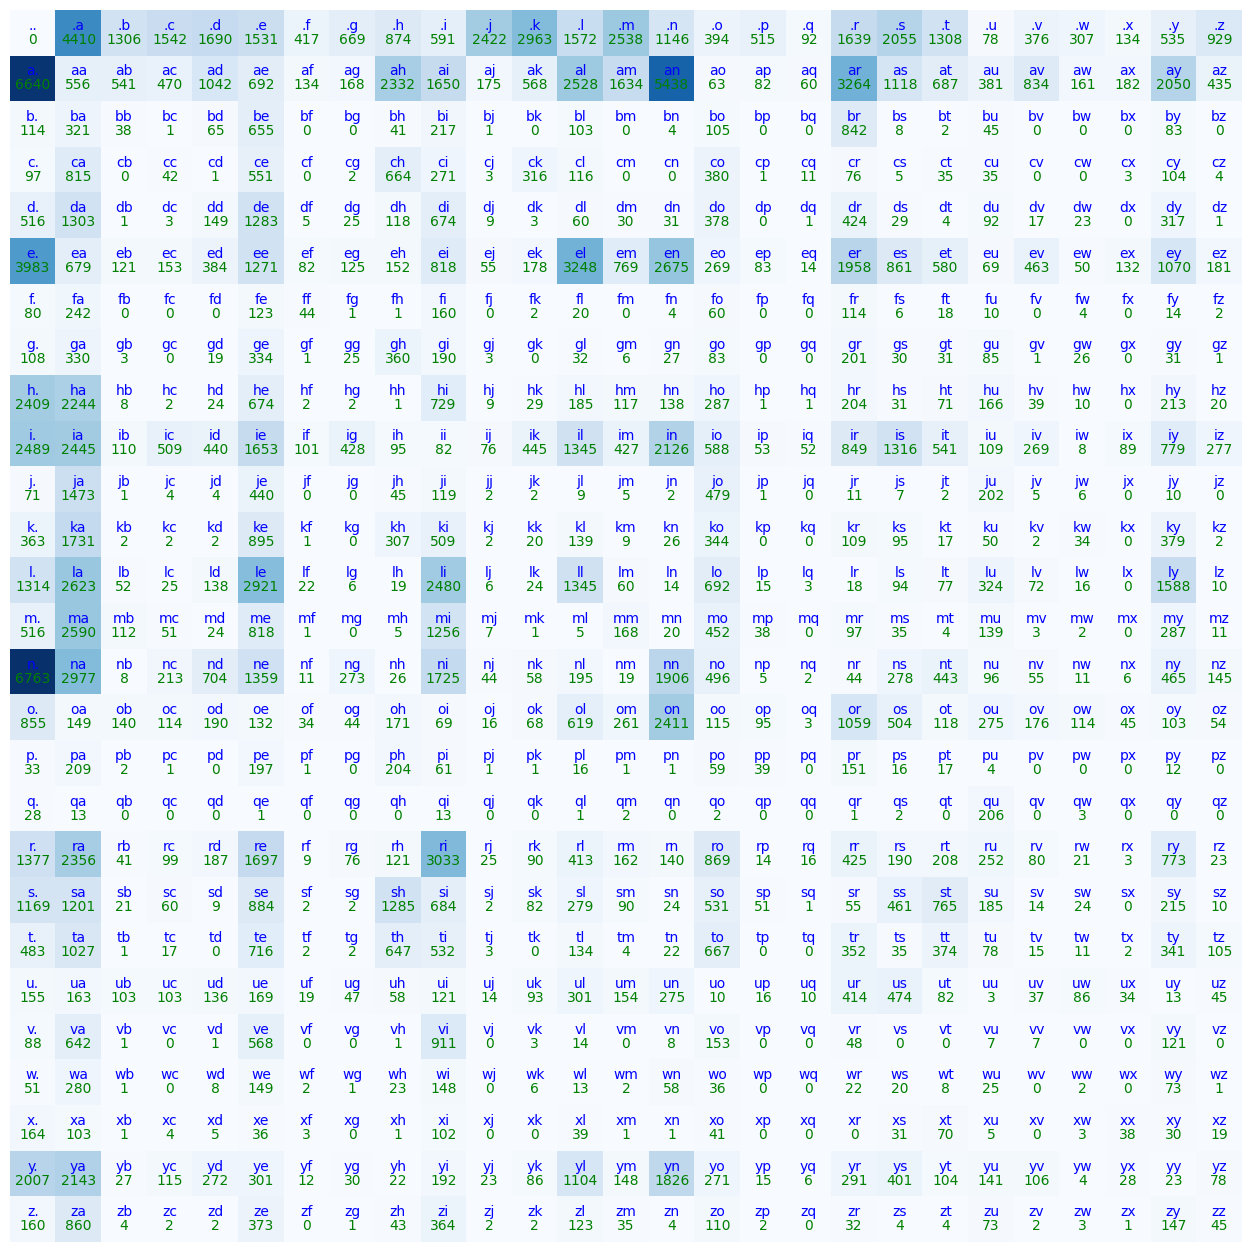

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")

itoch = {i:ch for ch, i in chtoi.items()}

for i in range(len(itoch)):
    for j in range(len(itoch)):
      chstr = itoch[i] + itoch[j]
      plt.text(j, i, chstr, ha="center", va="bottom", color="blue")
      plt.text(j, i, N[i, j].item(), ha="center", va="top", color="green")
plt.axis("off");
        

### Vectorized normalization of the rows, tensor broadcasting

Sources: 

https://pytorch.org/docs/stable/notes/broadcasting.html

https://numpy.org/doc/stable/user/basics.broadcasting.html

In [12]:
P = (N+1).float()     # add-one smoothing
P /= P.sum(dim=1, keepdim=True)

### Sampling from the model

In [13]:
g = torch.Generator().manual_seed(42)

for i in range(5):
    out = []
    ix = 0
    while True:
      p = P[ix]
      ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      out.append(itoch[ix])
      if ix == 0:
        break

    print("".join(out))

anugeenvi.
s.
mabidushan.
stan.
silaylelaremah.


### Loss function

Evaluation of the quality of the model, summarized as a single number that reflects how well the model predicts the data on the training set.

The negative log likelihood (NLL) is used as the loss function due to its semantics, such as low representing high accuracy. It is represented by the inversion of the sum of the logarithm of the probabilities of each character in the data following the previous character, as given by the bigram model, divided by the number of characters in the data.

Consider the sum of the logarithm of all characters: log(a*b*c) = log(a) + log(b) + log(c)

The negative log likelihood is the negative of the sum of the logarithm of all characters: -log(a*b*c) = -log(a) - log(b) - log(c)

The logarithm of a probability varying from 0 to 1 is always negative, so the negative log likelihood is always positive.

<img src="../assets/negative-log-likelihood.jpg" width="400"/>

Sources:

https://en.wikipedia.org/wiki/Maximum_likelihood_estimation

In [14]:
log_likelihood = 0.0
m = 0.0

for n in names[:3]:
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = chtoi[ch1]
        idx2 = chtoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        m += 1.0

nll = -log_likelihood / m
print(f"{log_likelihood=:.3f}")
print(f"{nll=:.3f}")

log_likelihood=-38.809
nll=2.426


In [15]:
log_likelihood = 0.0
m = 0.0

for n in ["marcos"]:
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = chtoi[ch1]
        idx2 = chtoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        m += 1.0

nll = -log_likelihood / m
print(f"{log_likelihood=:.3f}")
print(f"{nll=:.3f}")

log_likelihood=-17.599
nll=2.514


<strong>Conclusion: this does not look great. It can be seen that bigram LM is not very good at generating text. It is not able to learn the structure of the language, and it is not able to learn the probability of a character appearing in a given position in the text. We need to do better!<strong>

## PART I(b): Recurrent Neural Network Language Model

A neural network as a bigram character level language model that receives a single character as an input and outputs the probability distribution over the next character in a sequence. The model will be evaluated by the negative log likelihood loss function using the labels as the next character in the sequence and then gradient based optimization will be used to tune the weights of the model, so that the neural net learns to predict the next character in the sequence.

### Creating the bigram training dataset for the RNN

Each (x, y) bigram consists of a single character x and the next character y in the sequence, such as given the first character of a bigram, the neural net should try to predict the next one.

Since the neural net is made of neurons, each bigram must be represented as a one-hot encoded vector, where the index of the character is set to 1 and the rest are set to 0, and then the weights of each "synapse" are multiplied by the value of the corresponding character in the vector.

<img src="../assets/neural-network.jpg" width="600"/>

In [16]:
xs, ys = [], []

for n in names:
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = chtoi[ch1]
        idx2 = chtoi[ch2]
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

number of examples:  228146


In [17]:
xs[:10]

tensor([ 0,  5, 13, 13,  1,  0, 15, 12,  9, 22])

In [18]:
ys[:10]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])

In [19]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=len(chtoi)).float()     # input/activation matrix of shape (synapses, possible dimensions)
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [20]:
xenc.shape

torch.Size([228146, 27])

In [21]:
xenc.dtype

torch.float32

### The "neural net": one linear layer of neurons implemented with matrix multiplication

Neurons perform a function of type w * x + b, where w is the weight matrix, x is the input vector and b is the bias vector. The weight matrix is a 2D array where each row represents a neuron and each column represents a synapse. The bias vector is a 1D array where each element represents a neuron.

Using matrix multiplication, it is possible to very efficiently evaluate the dot product between inputs and neurons in parallel batchs.

Each neuron activation

In [22]:
W = torch.randn((len(chtoi), 1), generator=g)     # random weights matrix of shape (27 dimensions, 1 output neuron)
W

tensor([[-2.4691],
        [-1.6101],
        [ 1.7437],
        [-0.3877],
        [ 0.7723],
        [ 0.2267],
        [-0.3838],
        [-0.7681],
        [ 1.8044],
        [ 1.4647],
        [ 0.2913],
        [-0.1790],
        [-0.6752],
        [-0.7516],
        [-1.4113],
        [ 1.8677],
        [-0.9822],
        [-0.9581],
        [ 1.7746],
        [-0.8642],
        [-0.2884],
        [-1.0859],
        [-0.2322],
        [ 0.8948],
        [-0.1195],
        [ 0.7854],
        [-0.5618]])

In [23]:
xenc @ W     # @ is matrix multiplication in PyTorch .'. (x, 27) @ (27, 1) -> (x synapses, 1 output neuron)

tensor([[-2.4691],
        [ 0.2267],
        [-0.7516],
        ...,
        [ 0.7854],
        [-0.5618],
        [-0.1195]])

In [24]:
W = torch.randn((len(chtoi), len(chtoi)), generator=g, requires_grad=True)     # random weights matrix of shape
xenc @ W                                                                       # (x, 27) @ (27, 27) -> (x synapses, 27 neurons)

tensor([[-1.2998, -0.9024, -2.4198,  ...,  0.9816,  0.1761,  0.1009],
        [-2.2118,  0.8195,  0.8826,  ...,  0.3144, -0.1915,  0.8161],
        [-0.9816,  0.0353, -0.6148,  ..., -0.3845,  1.6740,  1.3828],
        ...,
        [-0.7853,  1.0901, -0.0665,  ...,  1.1272,  0.5445, -0.2186],
        [ 0.4121, -1.1325, -0.0616,  ..., -0.5553,  0.8257,  1.3953],
        [-0.0343, -0.5655,  0.4398,  ...,  0.4749,  0.8569, -0.7365]],
       grad_fn=<MmBackward0>)

In [25]:
(xenc @ W).shape

torch.Size([228146, 27])

## Transforming neural nets outputs into probabilities: the softmax function

After feeding the inputs into a layer of a neural net, the output is a vector of numbers that are not probabilities, since they do not sum to 1. The softmax function is used to transform the output vector into a probability distribution, where each element is a probability of the corresponding character being the next character in the sequence, thus creating precise semantics for the loss function.

The result of the matrix multiplication are negative and positive log counts (considering the weights were generated from a normal distribution). So, to get the counts, the exponential function is applied element-wise to the output of the matrix multiplication.

Exponentiation is a monotonic function that takes the entire real line and maps it to the positive real line, tending towards zero as the input tends towards negative infinity and tending towards infinity as the input tends towards positive infinity.

<img src="../assets/softmax-graph.jpg" width="400"/>

The softmax function is represented by the normalized probabilities derived from the log-counts of each letter. Softmax is an often used layer of a neural net that takes the output of the previous layer as logits, exponentiates them, divide and normalize. It is a way of transforming the output of a neural net into a probability distribution.

<img src="../assets/softmax-function.jpg" width="400"/>

The probability distribution being differentiable, it can be backpropagated through the neural net to tune the weights. Thus, the question of how to transform the output of the neural net into a probability distribution is solved. So, now the question is: can we optimize the weights of the neural net so that it learns to predict the next character in the sequence?

In [26]:
logits = xenc @ W                                    # log-counts of each letter in the alphabet
counts = logits.exp()                                # equivalent to N
probs = counts / counts.sum(dim=1, keepdim=True)     # normalization of counts (softmax)
probs

tensor([[0.0044, 0.0065, 0.0014,  ..., 0.0427, 0.0191, 0.0177],
        [0.0023, 0.0476, 0.0507,  ..., 0.0288, 0.0173, 0.0475],
        [0.0061, 0.0168, 0.0088,  ..., 0.0110, 0.0864, 0.0646],
        ...,
        [0.0110, 0.0721, 0.0227,  ..., 0.0748, 0.0418, 0.0195],
        [0.0362, 0.0077, 0.0226,  ..., 0.0138, 0.0548, 0.0968],
        [0.0266, 0.0157, 0.0428,  ..., 0.0443, 0.0650, 0.0132]],
       grad_fn=<DivBackward0>)

In [27]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [28]:
probs.shape

torch.Size([228146, 27])

In [29]:
nlls = torch.zeros(1)

print("example for the first bigram:")
x = xs[0].item()     # input character index
y = ys[0].item()     # output character index
print("------------------")
print(f"bigram example: {itoch[x]}{itoch[y]} (indexes {x}, {y})")
print(f"input to the neural net: {x}")
print(f"output probabilities from the neural net: {probs[0]}")
print(f"label (actual next character): {y}")
p = probs[0, y]
print(f"probability of the actual next character: {p.item()}")
logp = torch.log(p)
print(f"log likelihood of the actual next character: {logp.item()}")
nll = -logp
print(f"negative log likelihood of the actual next character: {nll.item()}")
nlls[0] = nll

print("=================")
print(f"average negative log likelihood, i.e. loss: {nlls.mean().item()}")

example for the first bigram:
------------------
bigram example: .e (indexes 0, 5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0044, 0.0065, 0.0014, 0.0327, 0.0023, 0.0088, 0.0072, 0.0164, 0.1290,
        0.0438, 0.0141, 0.0198, 0.0044, 0.1487, 0.0365, 0.0252, 0.0195, 0.0196,
        0.0078, 0.0213, 0.0876, 0.1822, 0.0207, 0.0607, 0.0427, 0.0191, 0.0177],
       grad_fn=<SelectBackward0>)
label (actual next character): 5
probability of the actual next character: 0.008753664791584015
log likelihood of the actual next character: -4.738282680511475
negative log likelihood of the actual next character: 4.738282680511475
average negative log likelihood, i.e. loss: 4.738282680511475


## Vectorized loss and Gradient Descent

Evaluate the loss using negative log likelihood, since the problem deals with classification.

Something magical happens in the backward pass, where the gradients are computed. The gradients are computed by the chain rule, which is a way of computing the derivative of a function composed of other functions. The chain rule is used to compute the derivative of the loss function with respect to the weights of the neural net, so that the weights can be updated using gradient descent.

In [30]:
loss = -probs[torch.arange(num), ys].log().mean()
loss

tensor(3.8246, grad_fn=<NegBackward0>)

In [31]:
# backward pass
W.grad = None       # set the gradients to zero
loss.backward()     # something MAGICAL happens here!

In [32]:
W.data -= 10 * W.grad     # update the weights

In [33]:
logits = xenc @ W                                    # log-counts of each letter in the alphabet
counts = logits.exp()                                # equivalent to N
probs = counts / counts.sum(dim=1, keepdim=True)     # normalization of counts (softmax)

In [34]:
loss = -probs[torch.arange(num), ys].log().mean()
loss

tensor(3.7400, grad_fn=<NegBackward0>)

In [35]:
for i in range(5):
    # forward pass
    logits = xenc @ W                                    
    counts = logits.exp()                                
    probs = counts / counts.sum(dim=1, keepdim=True)     
    loss = -probs[torch.arange(num), ys].log().mean()
    print(f"loss: {loss.item()}")

    # backward pass
    W.grad = None
    loss.backward()

    # update the weights
    W.data -= 10 * W.grad

    loss_data = loss.item()

loss: 3.739954948425293
loss: 3.6630940437316895
loss: 3.5925819873809814
loss: 3.527527093887329
loss: 3.467351198196411


## Putting everything together

In [36]:
xs, ys = [], []

for n in names:
    chs = ["."] + list(n) + ["."]     # . denotes special start/end token
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = chtoi[ch1]
        idx2 = chtoi[ch2]
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

# initialize the network
g = torch.Generator().manual_seed(42)
W = torch.randn((len(chtoi), len(chtoi)), generator=g, requires_grad=True)

number of examples:  228146


In [37]:
# gradient descent
for k in range(5):
    # forward pass
    xenc = F.one_hot(xs, num_classes=len(chtoi)).float()     # input/activation matrix of shape (synapses, possible dimensions)
    logits = xenc @ W                                        # log-counts of each letter in the alphabet
    counts = logits.exp()                                    # equivalent to N
    probs = counts / counts.sum(dim=1, keepdim=True)         # normalization of counts (softmax)
    loss = -probs[torch.arange(num), ys].log().mean()        # negative log likelihood
    print(f"loss: {loss.item()}")

    # backward pass
    W.grad = None                                            # set the gradients to zero
    loss.backward()                                          # backpropagate the loss

    # update weights
    W.data -= 50 * W.grad                                    # gradient descent

loss: 3.696648120880127
loss: 3.365849256515503
loss: 3.1507301330566406
loss: 3.0080673694610596
loss: 2.9114675521850586


### Sampling from the models and comparing the outputs

In [38]:
print("Sampling from the bigram model:")
for i in range(5):
    out = []
    ix = 0

    while True:
        p = P[ix]

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoch[ix])

        if ix == 0:
            break
    
    print("".join(out))

Sampling from the bigram model:
than.
txavylliyawol.
li.
a.
i.


In [39]:
print("Sampling from the neural net model:")
for i in range(5):
    out = []
    ix = 0

    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(chtoi)).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoch[ix])

        if ix == 0:
            break
    
    print("".join(out))

Sampling from the neural net model:
bimhelahmbinmhimzdelwranayzerhcuka.
salw.
sywli.
ph.
allayupmien.


### Wrap up

We would expect the loss from the neural net to be something around what we had originally with the bigram model. 

The bigram model optimizes just by counting, while the neural net achieves roughly the same result, but using gradient descent optimization. That makes sense because fundamentally we are not taking any additional information, that is, we are still just taking the previous character and trying to predict the next character, but instead of doing it explicitly, by counting and normalizing, we are doing it implicitly, by learning the weights of the neural net.

So, consider that the gradient based approach is significantly more flexible, so we can now expand this approach and complexify it to learn more complex patterns in the data. For instance, we can take multiple previous characters and try to predict the next character, instead of just one previous character. This is called an n-gram model, where n is the number of previous characters.

In any case, the output of the neural would still fundamentally be logits that would go through the exact same transformation of the softmax function, then calculate the loss function and the negative loss likelihood and then backpropagate the gradients to update the weights of the neural net. None of this will fundamentally change all the way up to transformers.

In contrast, it is not obvious how we would extend the bigram approach to learn more complex patterns in the data.

### Sources

https://www.youtube.com/watch?v=PaCmpygFfXo